In [1]:
import numpy as np
import pickle

import torch
import arviz as az
import numpy as np # 1.19.0
import scipy.special
import seaborn as sns
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer

from dingo.gw.ASD_dataset.noise_dataset import ASDDataset
from dingo.core.models import PosteriorModel
from dingo.gw.inference import injection
from dingo.gw.inference.gw_samplers import GWSamplerGNPE, GWSampler


%matplotlib inline
%load_ext autoreload
%autoreload 2

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-_1z6uj5c because the default path (/home/nihargupte/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
charizard_hex = ('#cd5241', '#084152', '#eede7b', '#207394', '#eeb45a', '#e64110', '#ff524a', '#f6a410', '#08398b', '#626262', '#833118')
plt.rcParams['text.usetex'] = False
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['font.size'] = 20
plt.rcParams['xtick.major.size'] = 8.0
plt.rcParams['xtick.minor.size'] = 6.0
plt.rcParams['ytick.major.size'] = 8.0
plt.rcParams['ytick.minor.size'] = 6.0
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=charizard_hex)

In [7]:
torch.cuda.set_device(0)

# build posterior model
main_pm = PosteriorModel(
    device="cuda",
    **{"model_filename": "/home/local/nihargupte/dingo-devel/tutorials/06_tgr/train_dir_SEOBNRv4HM_PA_O1_2048/model_latest.pt"},
    load_training_info=False
)

time_pm = PosteriorModel(
    device='cuda',
    **{"model_filename": "/home/local/nihargupte/dingo-devel/tutorials/06_tgr/train_dir_SEOBNRv4HM_PA_O1_2048_time/model_latest.pt"},
    load_training_info=False
)

init_sampler = GWSampler(model=time_pm)
sampler = GWSamplerGNPE(model=main_pm, init_sampler=init_sampler, num_iterations=30)

Putting posterior model to device cuda.
Putting posterior model to device cuda.
GNPE parameters:  ['H1_time', 'L1_time']


In [9]:
# Generating an injection for the network to do inference on
injection_generator = injection.Injection.from_posterior_model_metadata(main_pm.metadata)

# Opening up a asd
asd_dataset = ASDDataset(file_name= "/home/local/nihargupte/dingo-devel/tutorials/03_aligned_spin/datasets/ASDs_new/1024_1/asds_O1.hdf5")
asd = asd_dataset.sample_random_asds()
injection_generator.asd = asd
injection_generator.whiten = False

# Simulate data that is drawn from a gaussian distribution, see if we can recove the "hyperposterior"
n_hyper_injections = 30
injection_parameters = injection_generator.prior.sample(n_hyper_injections)
# Doing a hyper injection
true_dtau220_mu_sigma = {"mu":.2, "sigma": .4}
true_domega220_mu_sigma = {"mu":-.3, "sigma": .3}
dtau220_injection_values = np.random.normal(loc=true_dtau220_mu_sigma["mu"], scale=true_dtau220_mu_sigma["sigma"], size=n_hyper_injections)
domega220_injection_values = np.random.normal(loc=true_domega220_mu_sigma["mu"], scale=true_domega220_mu_sigma["sigma"], size=n_hyper_injections)
injection_parameters["dtau220"] = dtau220_injection_values
injection_parameters["domega220"] = domega220_injection_values
injection_parameters = [{k:v[i] for k, v in injection_parameters.items()} for i in range(injection_parameters["chirp_mass"].shape[0])]

# with open("/home/local/nihargupte/dingo-devel/tutorials/06_tgr/dumps/pystan/injection_params.pkl", "wb") as f:
#     pickle.dump(injection_parameters, f)


Loading dataset from /home/local/nihargupte/dingo-devel/tutorials/03_aligned_spin/datasets/ASDs_new/1024_1/asds_O1.hdf5.


In [10]:
with open("/home/local/nihargupte/dingo-devel/tutorials/06_tgr/dumps/pystan/injection_params.pkl", "rb") as f:
    injection_parameters = pickle.load(f)
data = [injection_generator.injection(parameters) for parameters in injection_parameters]

# Getting Sample mu and sigma (the supposed best we can do with n_data)
true_sample_dtau220_mu_sigma = {"mu":np.mean(dtau220_injection_values), "sigma":np.std(dtau220_injection_values)}
true_sample_domega220_mu_sigma = {"mu":np.mean(domega220_injection_values), "sigma":np.std(domega220_injection_values)}

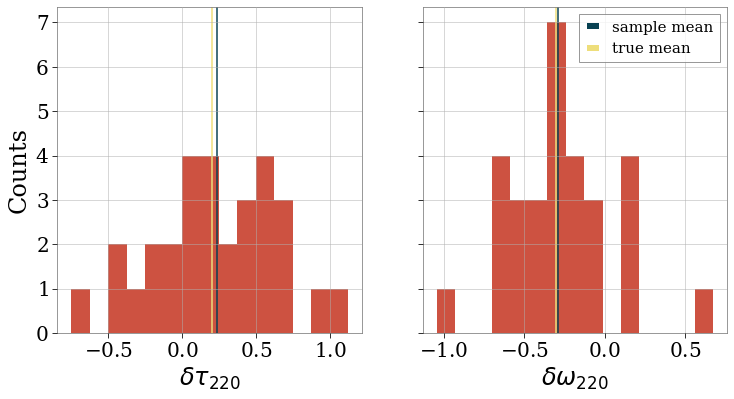

In [83]:
dtau220_injection_values = [injection_parameters[idx]["dtau220"] for idx in range(len(injection_parameters))]
domega220_injection_values = [injection_parameters[idx]["domega220"] for idx in range(len(injection_parameters))]
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
axes[0].set_xlabel(r"$\delta \tau_{220}$")
axes[0].set_ylabel("Counts")
axes[0].axvline(true_sample_dtau220_mu_sigma["mu"], color=charizard_hex[1], label="sample mean")
axes[0].axvline(true_dtau220_mu_sigma["mu"], color=charizard_hex[2], label="true mean")
axes[0].hist(dtau220_injection_values, bins=15)
axes[1].set_xlabel(r"$\delta \omega_{220}$")
axes[1].axvline(true_sample_domega220_mu_sigma["mu"], color=charizard_hex[1], label="sample mean")
axes[1].axvline(true_domega220_mu_sigma["mu"], color=charizard_hex[2], label="true mean")
axes[1].hist(domega220_injection_values, bins=15)
plt.legend()
plt.savefig("/home/local/nihargupte/dingo-devel/tutorials/06_tgr/plots/hyperinjection.png")

In [5]:
# Generating posteriors for the injections
# with open("/home/local/nihargupte/dingo-devel/tutorials/06_tgr/dumps/pystan/posteriors.pkl", "rb") as f:
#     posteriors = pickle.load(f)
posteriors = {}
for k, v in enumerate(data):
    sampler.context = v
    sampler.run_sampler(num_samples=50_000,batch_size=10_000)
    posteriors[k] = sampler.samples[["dtau220", "domega220"]]
posteriors = {k:np.array([posterior[k].to_numpy() for posterior in posteriors.values()]) for k in posteriors[0].columns}

with open("/home/local/nihargupte/dingo-devel/tutorials/06_tgr/dumps/pystan/posteriors.pkl", "wb") as f:
    pickle.dump(posteriors, f)

In [3]:
with open("/home/local/nihargupte/dingo-devel/tutorials/06_tgr/dumps/pystan/fits.pkl", "rb") as f:
    fits = pickle.load(f)
fits["domega220"] = fits["domega220"].to_dataframe()
fits["dtau220"] = fits["dtau220"].to_dataframe()
del fits["model"]

In [14]:
def ComputeSymCIedges(samples, ci=0.9):
    """ Symmetric CI.
    """
    lo = np.percentile(samples, 100.0 * (1-ci)*0.5)
    hi = np.percentile(samples, 100.0 * (1-(1-ci)*0.5))
    return hi, lo

for k, v in fits.items():
    print("\n" + k)
    # median
    mu_med = np.median(v['mu'])
    mu_ci1, mu_ci2 = ComputeSymCIedges(v['mu'], 0.90)
    # standard deviation
    sig_ul = np.percentile(v['sigma'], 90)
    print('\tmu:\t%.2f +%.2f -%.2f  [%.2f]' % (mu_med, mu_ci1-mu_med, mu_med-mu_ci2, mu_ci1-mu_ci2))
    print('\tsigma: < %.2f' % sig_ul)

print(f"\n dtau220: {true_sample_dtau220_mu_sigma}  \t domega220: {true_sample_domega220_mu_sigma}")


dtau220
	mu:	0.54 +0.18 -0.17  [0.35]
	sigma: < 0.31

domega220
	mu:	-0.40 +0.24 -0.19  [0.43]
	sigma: < 0.43

 dtau220: {'mu': 0.25559952553937265, 'sigma': 0.38355471847589356}  	 domega220: {'mu': -0.3303619900347547, 'sigma': 0.25001834548266744}


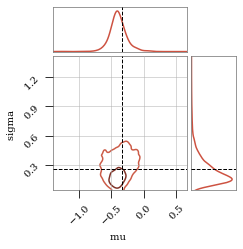

: 

In [25]:
N = 1
c = ChainConsumer()
c.add_chain(fits["domega220"][["mu", "sigma"]], color=charizard_hex[0], name='domega220')
c.configure(
    linestyles=["-"] * N,
    linewidths=[1.5] * N,
    sigmas=[np.sqrt(2) * scipy.special.erfinv(x) for x in [0.5, .9]],
    shade=[False] + [True] * (N - 1),
    shade_alpha=0.3,
    bar_shade=False,
    label_font_size=10,
    tick_font_size=10,
    usetex=False,
    legend_kwargs={"fontsize": 30},
    # kde=0.7
)

fig = c.plotter.plot(truth={"mu":true_sample_domega220_mu_sigma["mu"], "sigma":true_sample_domega220_mu_sigma["sigma"]})
fig.savefig("/home/local/nihargupte/dingo-devel/tutorials/06_tgr/plots/domega220.png", bbox_inches="tight")

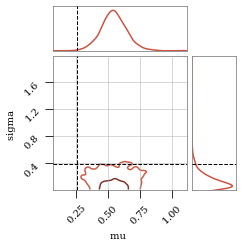

In [24]:
N = 1
c = ChainConsumer()
c.add_chain(fits["dtau220"][["mu", "sigma"]], color=charizard_hex[0], name=r"$\delta \tau_{220}$")
c.configure(
    linestyles=["-"] * N,
    linewidths=[1.5] * N,
    sigmas=[np.sqrt(2) * scipy.special.erfinv(x) for x in [0.5, .9]],
    shade=[False] + [True] * (N - 1),
    shade_alpha=0.3,
    bar_shade=False,
    label_font_size=10,
    tick_font_size=10,
    usetex=False,
    legend_kwargs={"fontsize": 30},
    # kde=0.7
)

fig = c.plotter.plot(truth={"mu":true_sample_dtau220_mu_sigma["mu"], "sigma":true_sample_dtau220_mu_sigma["sigma"]})
fig.savefig("/home/local/nihargupte/dingo-devel/tutorials/06_tgr/plots/dtau220.png", bbox_inches="tight")

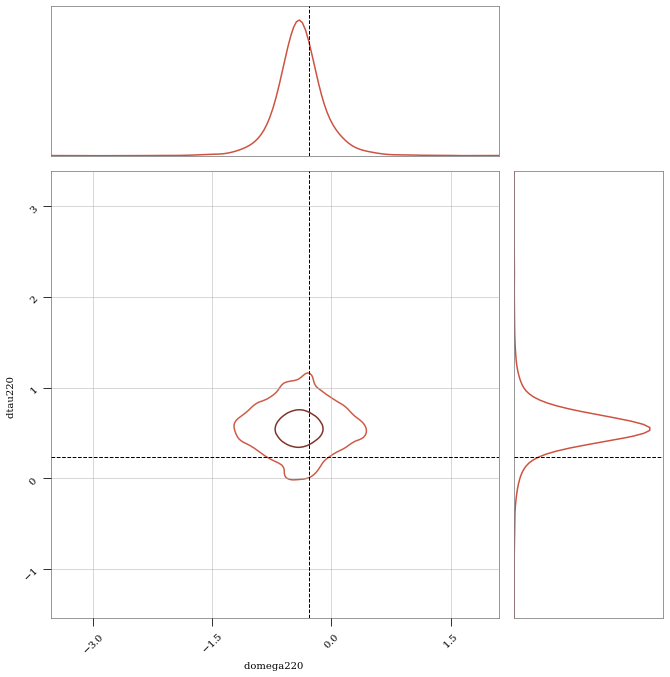

In [93]:
N = 1
c = ChainConsumer()
c.add_chain({"domega220":fits["domega220"]["pop"], "dtau220":fits["dtau220"]["pop"]}, color=charizard_hex[0], name='dtau220')
c.configure(
    linestyles=["-"] * N,
    linewidths=[1.5] * N,
    sigmas=[np.sqrt(2) * scipy.special.erfinv(x) for x in [0.5, .9]],
    shade=[False] + [True] * (N - 1),
    shade_alpha=0.3,
    bar_shade=False,
    label_font_size=10,
    tick_font_size=10,
    usetex=False,
    legend_kwargs={"fontsize": 30},
    # kde=0.7
)

fig = c.plotter.plot(truth={"domega220":true_sample_domega220_mu_sigma["mu"], "dtau220":true_sample_dtau220_mu_sigma["mu"]})
fig.set_figheight(10)
fig.set_figwidth(10)
fig.savefig("/home/local/nihargupte/dingo-devel/tutorials/06_tgr/plots/hyperinjection_posterior.png")

In [23]:
N = 1
c = ChainConsumer()
idx = 19
c.add_chain({"dtau220":posteriors["dtau220"][idx], "domega220":posteriors["domega220"][idx]}, color=charizard_hex[0])
c.configure(
    linestyles=["-"] * N,
    linewidths=[1.5] * N,
    sigmas=[np.sqrt(2) * scipy.special.erfinv(x) for x in [0.5, .9]],
    shade=[False] + [True] * (N - 1),
    shade_alpha=0.3,
    bar_shade=False,
    label_font_size=10,
    tick_font_size=10,
    usetex=False,
    legend_kwargs={"fontsize": 30},
    # kde=0.7
)

fig = c.plotter.plot(truth=injection_parameters[idx])
# fig.savefig("/home/local/nihargupte/dingo-devel/tutorials/06_tgr/plots/dtau220.png", bbox_inches="tight")

NameError: name 'posteriors' is not defined